In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker
import requests

# Fetch the GDP data for Germany, India, and World
df_full = pd.read_csv(
    "https://ourworldindata.org/grapher/gdp-worldbank-constant-usd.csv?v=1"
    "&csvType=filtered&useColumnShortNames=false&tab=chart&time=2002..2023&country=DEU~IND~OWID_WRL",
    storage_options={'User-Agent': 'Our World In Data data fetch/1.0'}
)

# Define the correct GDP column
gdp_col = "GDP (constant 2015 US$)"

# Convert the Year column to integers so that whole years (2002, 2003, …) are displayed
df_full['Year'] = df_full['Year'].astype(int)

# Filter the data for the period 2002 – 2023
df_full = df_full[(df_full['Year'] >= 2002) & (df_full['Year'] <= 2023)]

# Split into two separate datasets:
#   - Countries: India and Germany only
#   - World: World GDP separately (to avoid mixing very different scales)
df_countries = df_full[df_full['Entity'].isin(['India', 'Germany'])]
df_world = df_full[df_full['Entity'] == 'World']

# --- SCALING FOR COUNTRIES (India & Germany) --- #
# Determine scaling factor for countries
max_value_countries = df_countries[gdp_col].max()
if max_value_countries >= 1e12:
    scale_factor_countries = 1e12
    unit_label_countries = "Trillions (T)"
else:
    scale_factor_countries = 1e6
    unit_label_countries = "Millions (M)"

df_countries = df_countries.copy()  # avoid SettingWithCopy warning
df_countries['GDP_scaled'] = df_countries[gdp_col] / scale_factor_countries

# --- SCALING FOR WORLD --- #
max_value_world = df_world[gdp_col].max()
if max_value_world >= 1e12:
    scale_factor_world = 1e12
    unit_label_world = "Trillions (T)"
else:
    scale_factor_world = 1e6
    unit_label_world = "Millions (M)"

df_world = df_world.copy()
df_world['GDP_scaled'] = df_world[gdp_col] / scale_factor_world


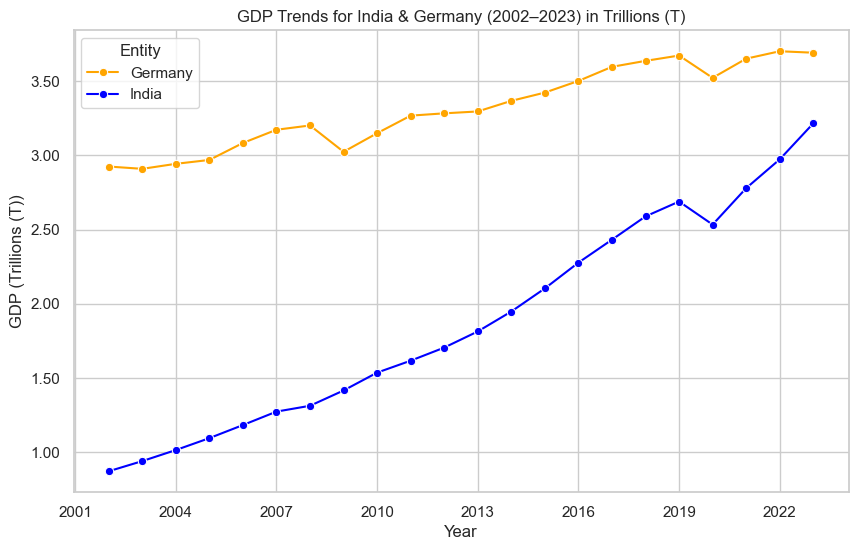

In [2]:
# Set a consistent visual style
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_countries, x='Year', y='GDP_scaled', hue='Entity', 
             palette={"India": "blue", "Germany": "orange"}, marker="o")
plt.title(f"GDP Trends for India & Germany (2002–2023) in {unit_label_countries}")
plt.xlabel("Year")
plt.ylabel(f"GDP ({unit_label_countries})")
plt.legend(title="Entity")
ax = plt.gca()
ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
ax.yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.2f}'))
plt.show()


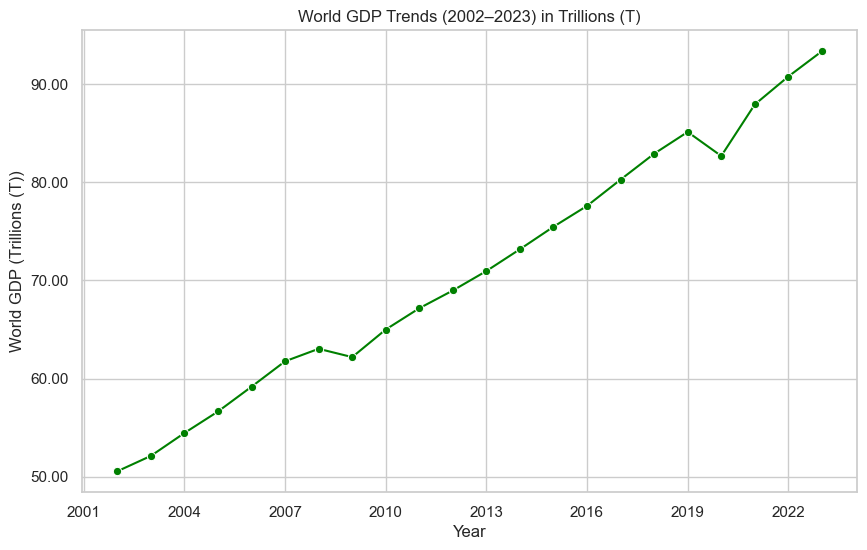

In [3]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_world, x='Year', y='GDP_scaled', marker="o", color="green")
plt.title(f"World GDP Trends (2002–2023) in {unit_label_world}")
plt.xlabel("Year")
plt.ylabel(f"World GDP ({unit_label_world})")
ax = plt.gca()
ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
ax.yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.2f}'))
plt.show()


In [4]:
# Calculate descriptive statistics for countries (scaled)
stats_india = df_countries[df_countries['Entity'] == 'India']['GDP_scaled'].describe()
stats_germany = df_countries[df_countries['Entity'] == 'Germany']['GDP_scaled'].describe()

print("Descriptive Statistics for India GDP:")
print(stats_india.apply(lambda x: f"{x:,.2f}"))

print("\nDescriptive Statistics for Germany GDP:")
print(stats_germany.apply(lambda x: f"{x:,.2f}"))

# Descriptive statistics for World GDP
stats_world = df_world['GDP_scaled'].describe()
print("\nDescriptive Statistics for World GDP:")
print(stats_world.apply(lambda x: f"{x:,.2f}"))


Descriptive Statistics for India GDP:
count    22.00
mean      1.88
std       0.72
min       0.87
25%       1.28
50%       1.76
75%       2.51
max       3.22
Name: GDP_scaled, dtype: object

Descriptive Statistics for Germany GDP:
count    22.00
mean      3.32
std       0.27
min       2.91
25%       3.10
50%       3.29
75%       3.58
max       3.70
Name: GDP_scaled, dtype: object

Descriptive Statistics for World GDP:
count    22.00
mean     70.97
std      12.88
min      50.57
25%      61.87
50%      69.97
75%      82.08
max      93.35
Name: GDP_scaled, dtype: object


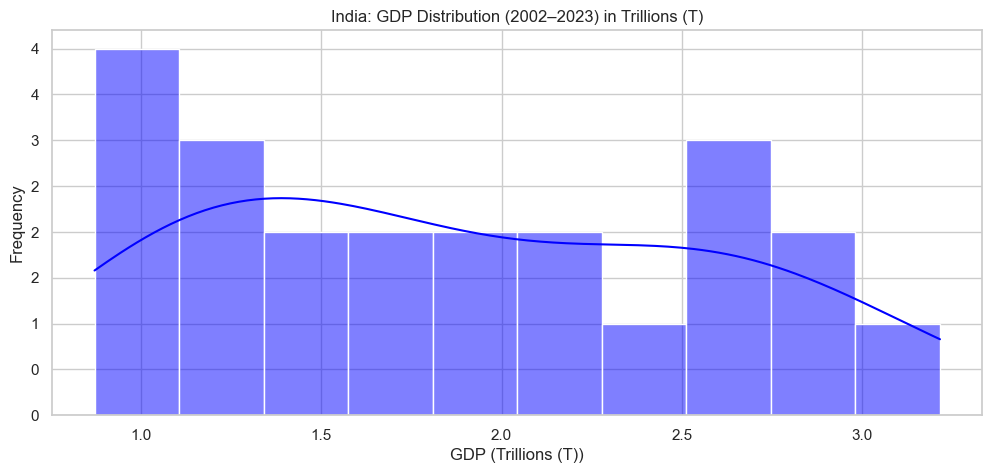

In [5]:
plt.figure(figsize=(12, 5))
sns.histplot(df_countries[df_countries['Entity'] == 'India']['GDP_scaled'], 
             kde=True, bins=10, color="blue")
plt.title(f"India: GDP Distribution (2002–2023) in {unit_label_countries}")
plt.xlabel(f"GDP ({unit_label_countries})")
plt.ylabel("Frequency")
plt.gca().yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))
plt.show()


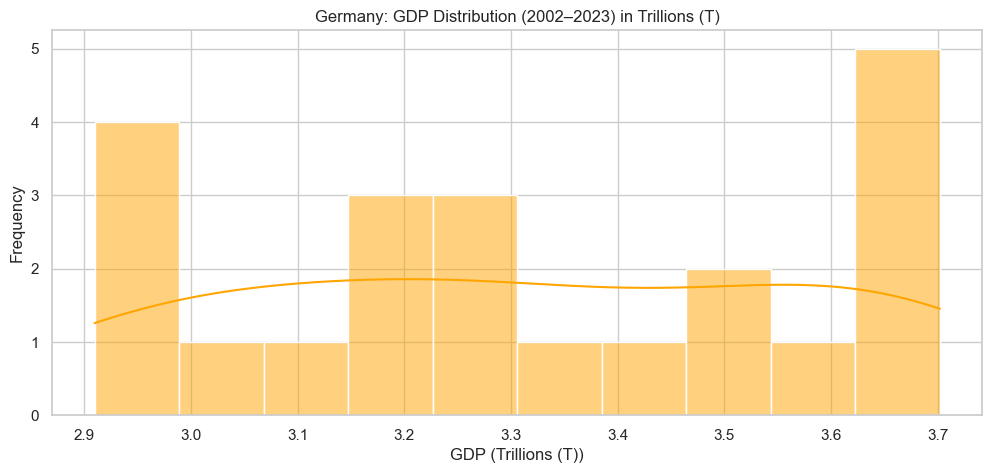

In [6]:
plt.figure(figsize=(12, 5))
sns.histplot(df_countries[df_countries['Entity'] == 'Germany']['GDP_scaled'], 
             kde=True, bins=10, color="orange")
plt.title(f"Germany: GDP Distribution (2002–2023) in {unit_label_countries}")
plt.xlabel(f"GDP ({unit_label_countries})")
plt.ylabel("Frequency")
plt.gca().yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))
plt.show()


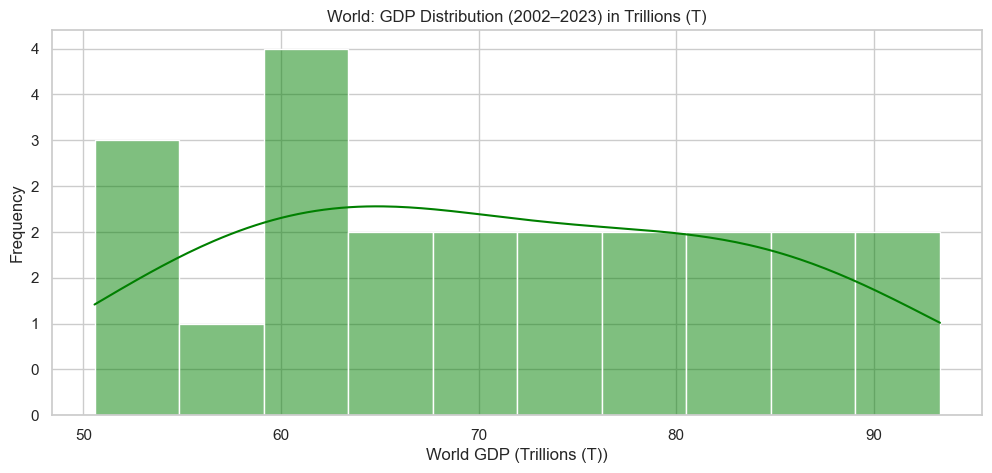

In [7]:
plt.figure(figsize=(12, 5))
sns.histplot(df_world['GDP_scaled'], kde=True, bins=10, color="green")
plt.title(f"World: GDP Distribution (2002–2023) in {unit_label_world}")
plt.xlabel(f"World GDP ({unit_label_world})")
plt.ylabel("Frequency")
plt.gca().yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))
plt.show()


In [8]:
from scipy.stats import norm

# Fit for India
mu_india, std_india = norm.fit(df_countries[df_countries['Entity'] == 'India']['GDP_scaled'])
# Fit for Germany
mu_germany, std_germany = norm.fit(df_countries[df_countries['Entity'] == 'Germany']['GDP_scaled'])
# (We could attempt a fit for world as well if desired)
mu_world, std_world = norm.fit(df_world['GDP_scaled'])

print(f"India: mu = {mu_india:,.2f} {unit_label_countries}, std = {std_india:,.2f} {unit_label_countries}")
print(f"Germany: mu = {mu_germany:,.2f} {unit_label_countries}, std = {std_germany:,.2f} {unit_label_countries}")
print(f"World: mu = {mu_world:,.2f} {unit_label_world}, std = {std_world:,.2f} {unit_label_world}")


India: mu = 1.88 Trillions (T), std = 0.70 Trillions (T)
Germany: mu = 3.32 Trillions (T), std = 0.27 Trillions (T)
World: mu = 70.97 Trillions (T), std = 12.58 Trillions (T)


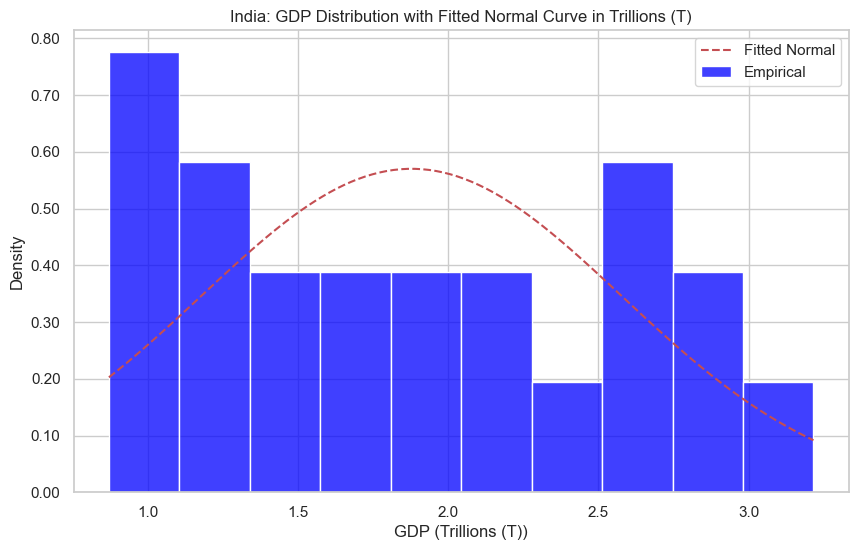

In [9]:
x_india = np.linspace(df_countries[df_countries['Entity'] == 'India']['GDP_scaled'].min(),
                        df_countries[df_countries['Entity'] == 'India']['GDP_scaled'].max(), 100)
pdf_india = norm.pdf(x_india, mu_india, std_india)

plt.figure(figsize=(10, 6))
sns.histplot(df_countries[df_countries['Entity'] == 'India']['GDP_scaled'], 
             kde=False, stat="density", bins=10, color="blue", label="Empirical")
plt.plot(x_india, pdf_india, 'r--', label="Fitted Normal")
plt.title(f"India: GDP Distribution with Fitted Normal Curve in {unit_label_countries}")
plt.xlabel(f"GDP ({unit_label_countries})")
plt.ylabel("Density")
plt.legend()
plt.gca().yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.2f}'))
plt.show()


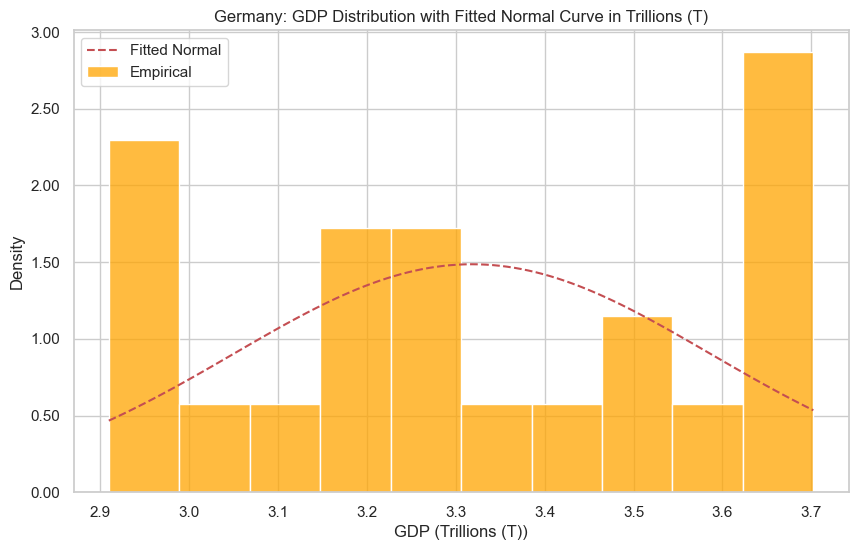

In [10]:
x_germany = np.linspace(df_countries[df_countries['Entity'] == 'Germany']['GDP_scaled'].min(),
                          df_countries[df_countries['Entity'] == 'Germany']['GDP_scaled'].max(), 100)
pdf_germany = norm.pdf(x_germany, mu_germany, std_germany)

plt.figure(figsize=(10, 6))
sns.histplot(df_countries[df_countries['Entity'] == 'Germany']['GDP_scaled'], 
             kde=False, stat="density", bins=10, color="orange", label="Empirical")
plt.plot(x_germany, pdf_germany, 'r--', label="Fitted Normal")
plt.title(f"Germany: GDP Distribution with Fitted Normal Curve in {unit_label_countries}")
plt.xlabel(f"GDP ({unit_label_countries})")
plt.ylabel("Density")
plt.legend()
plt.gca().yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.2f}'))
plt.show()


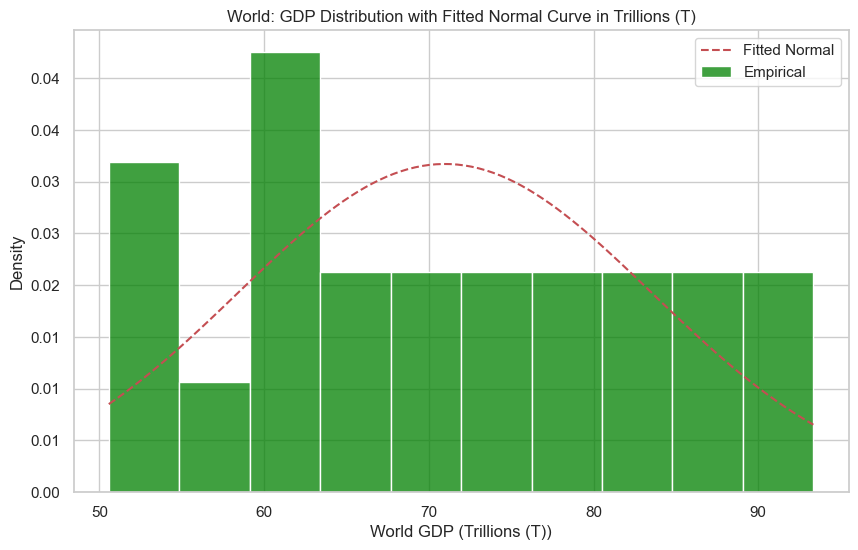

In [11]:
x_world = np.linspace(df_world['GDP_scaled'].min(), df_world['GDP_scaled'].max(), 100)
pdf_world = norm.pdf(x_world, mu_world, std_world)

plt.figure(figsize=(10, 6))
sns.histplot(df_world['GDP_scaled'], kde=False, stat="density", bins=10, color="green", label="Empirical")
plt.plot(x_world, pdf_world, 'r--', label="Fitted Normal")
plt.title(f"World: GDP Distribution with Fitted Normal Curve in {unit_label_world}")
plt.xlabel(f"World GDP ({unit_label_world})")
plt.ylabel("Density")
plt.legend()
plt.gca().yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.2f}'))
plt.show()


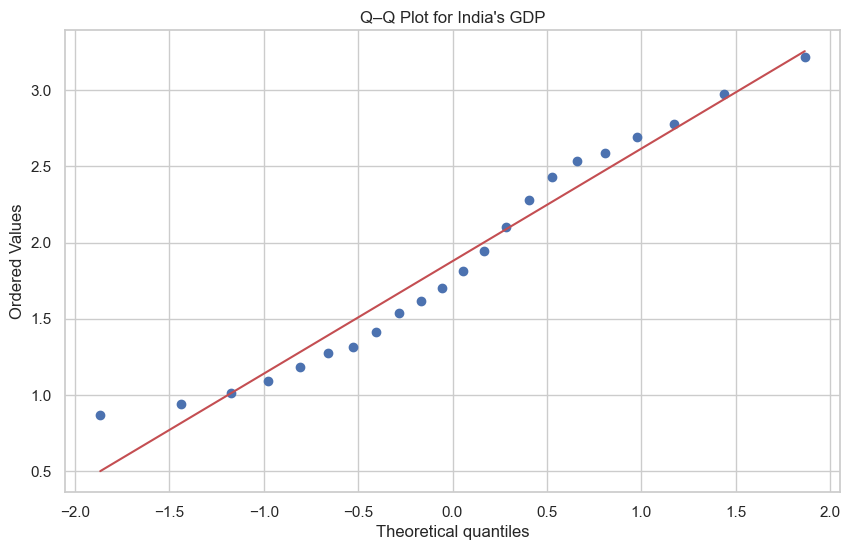

In [12]:
from scipy.stats import probplot

plt.figure(figsize=(10, 6))
probplot(df_countries[df_countries['Entity'] == 'India']['GDP_scaled'], dist="norm", plot=plt)
plt.title("Q–Q Plot for India's GDP")
plt.show()


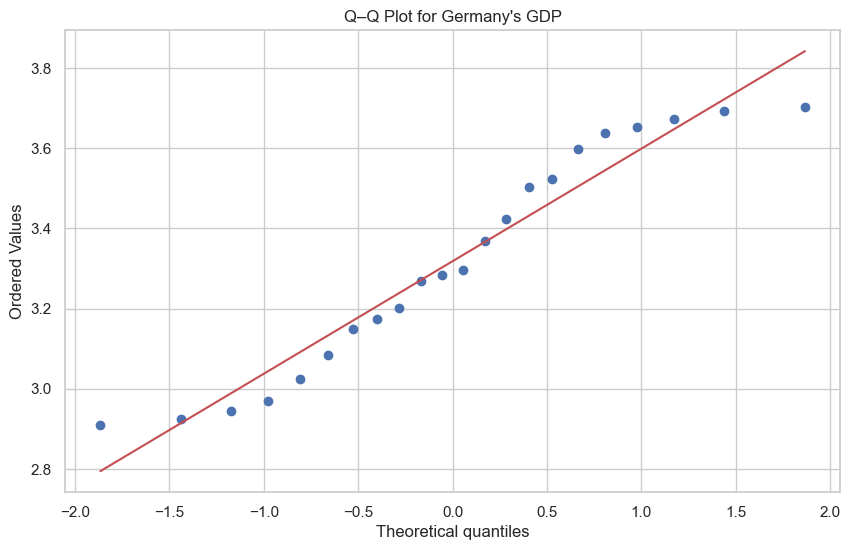

In [13]:
plt.figure(figsize=(10, 6))
probplot(df_countries[df_countries['Entity'] == 'Germany']['GDP_scaled'], dist="norm", plot=plt)
plt.title("Q–Q Plot for Germany's GDP")
plt.show()


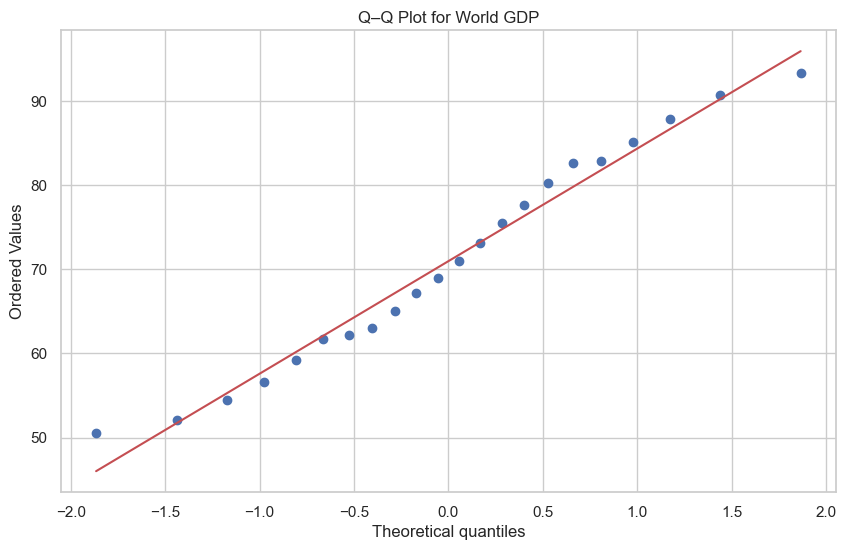

In [14]:
plt.figure(figsize=(10, 6))
probplot(df_world['GDP_scaled'], dist="norm", plot=plt)
plt.title("Q–Q Plot for World GDP")
plt.show()


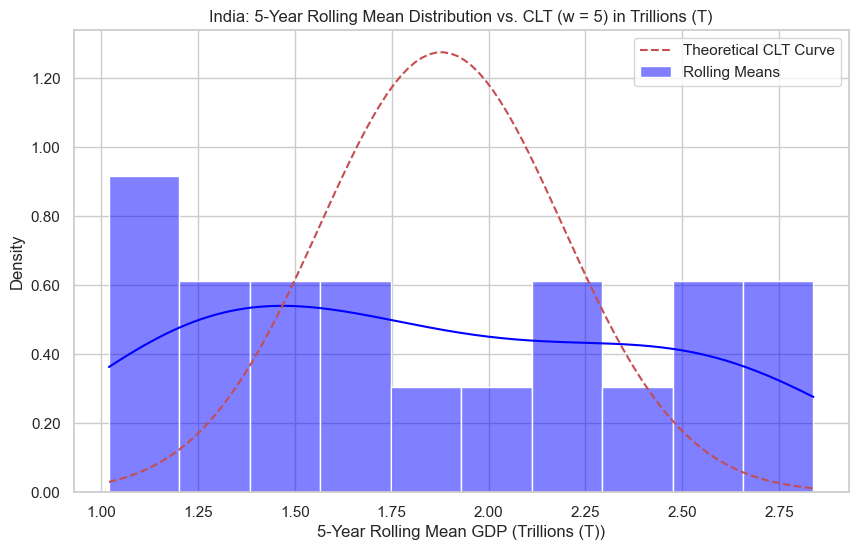

In [15]:
window_size = 5
df_india_sorted = df_countries[df_countries['Entity'] == 'India'].sort_values('Year')
rolling_india = df_india_sorted['GDP_scaled'].rolling(window=window_size).mean().dropna()
theo_std_india = std_india / np.sqrt(window_size)

x_roll_india = np.linspace(rolling_india.min(), rolling_india.max(), 100)
pdf_roll_india = norm.pdf(x_roll_india, mu_india, theo_std_india)

plt.figure(figsize=(10, 6))
sns.histplot(rolling_india, kde=True, bins=10, color="blue", stat="density", label="Rolling Means")
plt.plot(x_roll_india, pdf_roll_india, 'r--', label="Theoretical CLT Curve")
plt.title(f"India: 5-Year Rolling Mean Distribution vs. CLT (w = 5) in {unit_label_countries}")
plt.xlabel(f"5-Year Rolling Mean GDP ({unit_label_countries})")
plt.ylabel("Density")
plt.legend()
plt.gca().yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.2f}'))
plt.show()


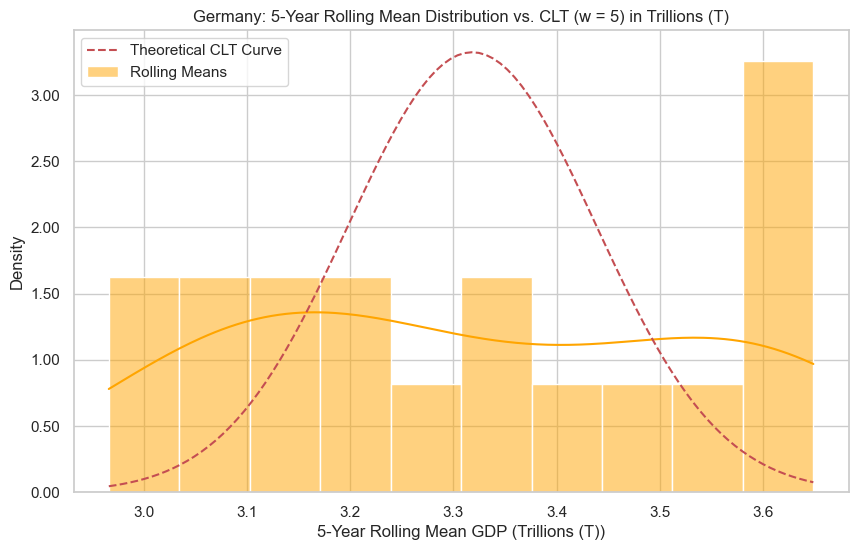

In [16]:
df_germany_sorted = df_countries[df_countries['Entity'] == 'Germany'].sort_values('Year')
rolling_germany = df_germany_sorted['GDP_scaled'].rolling(window=window_size).mean().dropna()
theo_std_germany = std_germany / np.sqrt(window_size)

x_roll_germany = np.linspace(rolling_germany.min(), rolling_germany.max(), 100)
pdf_roll_germany = norm.pdf(x_roll_germany, mu_germany, theo_std_germany)

plt.figure(figsize=(10, 6))
sns.histplot(rolling_germany, kde=True, bins=10, color="orange", stat="density", label="Rolling Means")
plt.plot(x_roll_germany, pdf_roll_germany, 'r--', label="Theoretical CLT Curve")
plt.title(f"Germany: 5-Year Rolling Mean Distribution vs. CLT (w = 5) in {unit_label_countries}")
plt.xlabel(f"5-Year Rolling Mean GDP ({unit_label_countries})")
plt.ylabel("Density")
plt.legend()
plt.gca().yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.2f}'))
plt.show()


Two-sample t-test results:
t-statistic: -8.804
p-value: 0.000


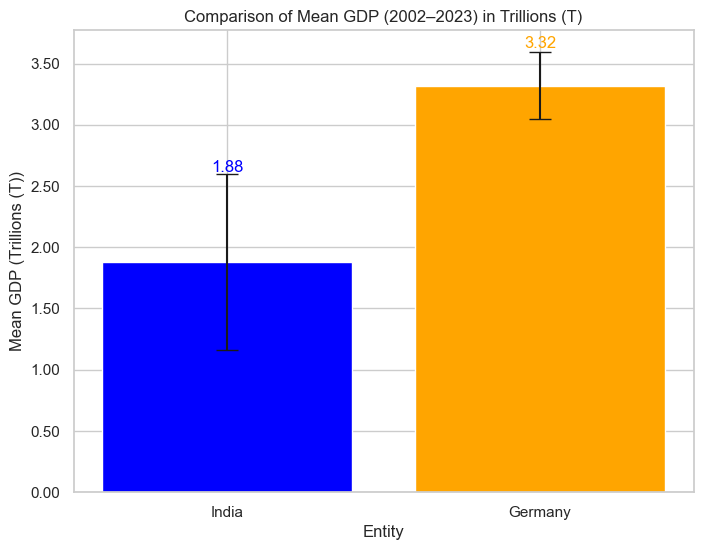

In [17]:
from scipy.stats import ttest_ind

# Extract GDP_scaled series for India and Germany
gdp_india = df_countries[df_countries['Entity'] == 'India']['GDP_scaled']
gdp_germany = df_countries[df_countries['Entity'] == 'Germany']['GDP_scaled']

# Perform two-sample t-test (Welch’s t-test)
t_stat, p_value = ttest_ind(gdp_india, gdp_germany, equal_var=False)
print("Two-sample t-test results:")
print(f"t-statistic: {t_stat:,.3f}")
print(f"p-value: {p_value:,.3f}")

# Create a bar chart comparing mean GDP for India and Germany
means = [gdp_india.mean(), gdp_germany.mean()]
std_devs = [gdp_india.std(), gdp_germany.std()]
countries = ['India', 'Germany']

plt.figure(figsize=(8, 6))
bars = plt.bar(countries, means, yerr=std_devs, color=["blue", "orange"], capsize=8)
plt.title(f"Comparison of Mean GDP (2002–2023) in {unit_label_countries}")
plt.xlabel("Entity")
plt.ylabel(f"Mean GDP ({unit_label_countries})")
plt.gca().yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.2f}'))
plt.text(0, means[0] + std_devs[0] + 0.01*means[0], f"{means[0]:,.2f}", ha='center', color="blue")
plt.text(1, means[1] + std_devs[1] + 0.01*means[1], f"{means[1]:,.2f}", ha='center', color="orange")
plt.show()


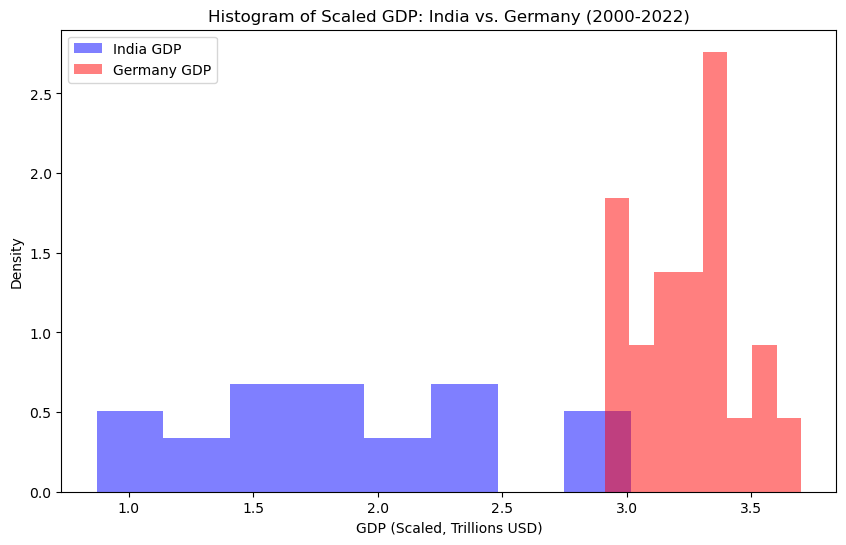

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# Function to generate GDP data based on descriptive statistics
def generate_gdp_data(mean, std, min_val, max_val, count):
    # Generate normal distribution and clip to fit min/max
    data = np.random.normal(mean, std, count)
    data = np.clip(data, min_val, max_val)
    return data

# Parameters from descriptive statistics
india_gdp = generate_gdp_data(mean=1.88, std=0.72, min_val=0.87, max_val=3.22, count=22)
germany_gdp = generate_gdp_data(mean=3.32, std=0.27, min_val=2.91, max_val=3.70, count=22)

# Create histogram
plt.figure(figsize=(10, 6))
plt.hist(india_gdp, bins=8, color='blue', alpha=0.5, label='India GDP', density=True)
plt.hist(germany_gdp, bins=8, color='red', alpha=0.5, label='Germany GDP', density=True)

# Add labels and title
plt.xlabel('GDP (Scaled, Trillions USD)')
plt.ylabel('Density')
plt.title('Histogram of Scaled GDP: India vs. Germany (2000-2022)')
plt.legend()

# Save the plot
plt.savefig('india_germany_gdp_histogram.png')

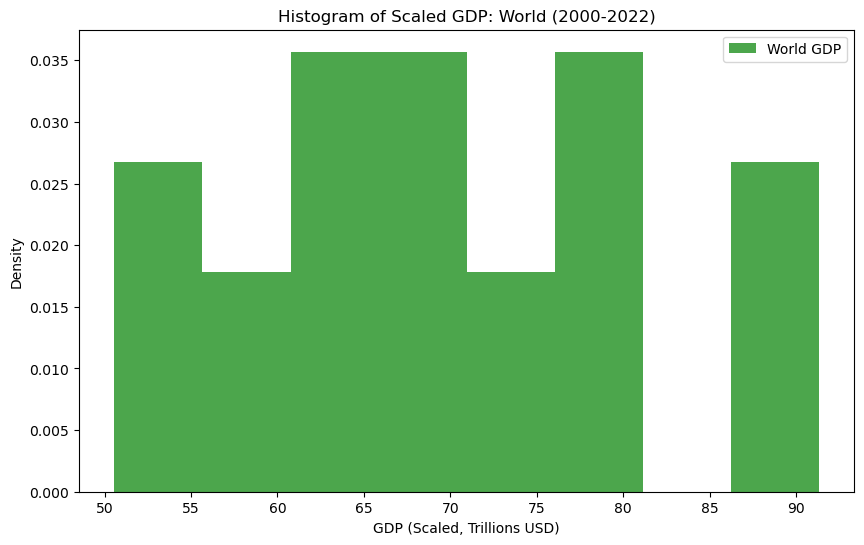

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# Function to generate GDP data based on descriptive statistics
def generate_gdp_data(mean, std, min_val, max_val, count):
    # Generate normal distribution and clip to fit min/max
    data = np.random.normal(mean, std, count)
    data = np.clip(data, min_val, max_val)
    return data

# Parameters from descriptive statistics for World
world_gdp = generate_gdp_data(mean=70.97, std=12.88, min_val=50.57, max_val=93.35, count=22)

# Create histogram
plt.figure(figsize=(10, 6))
plt.hist(world_gdp, bins=8, color='green', alpha=0.7, label='World GDP', density=True)

# Add labels and title
plt.xlabel('GDP (Scaled, Trillions USD)')
plt.ylabel('Density')
plt.title('Histogram of Scaled GDP: World (2000-2022)')
plt.legend()

# Save the plot
plt.savefig('world_gdp_histogram.png')

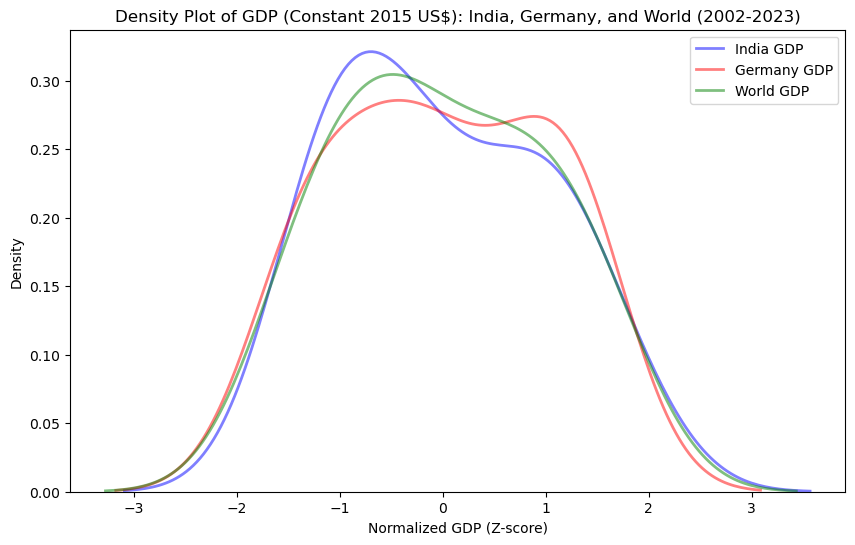

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

# GDP data (constant 2015 US$) for Germany, India, and World (2002-2023)
germany_gdp = np.array([
    2925076200000, 2909575300000, 2943395300000, 2969464700000, 3083959500000,
    3173089300000, 3201977000000, 3024422200000, 3149838000000, 3268208000000,
    3283708800000, 3296391300000, 3367906300000, 3423568400000, 3502129500000,
    3597248200000, 3637409500000, 3673343100000, 3522914700000, 3652205700000,
    3702231000000, 3692367000000
])
india_gdp = np.array([
    871073100000, 939542800000, 1013982170000, 1094324300000, 1182534900000,
    1273126700000, 1312424300000, 1415605600000, 1535897900000, 1616399200000,
    1704596200000, 1813453500000, 1947834500000, 2103588400000, 2277267000000,
    2432016000000, 2588974800000, 2689205300000, 2533830400000, 2779348200000,
    2973542400000, 3215973400000
])
world_gdp = np.array([
    50567137000000, 52131516000000, 54463870000000, 56653580000000, 59180665000000,
    61768750000000, 63038810000000, 62192600000000, 65002107000000, 67170764000000,
    68978974000000, 70960630000000, 73182745000000, 75472470000000, 77596070000000,
    80274256000000, 82909020000000, 85127640000000, 82677380000000, 87927480000000,
    90774590000000, 93346685000000
])

# Normalize GDP data using z-scores for comparable density plots
germany_gdp_norm = zscore(germany_gdp)
india_gdp_norm = zscore(india_gdp)
world_gdp_norm = zscore(world_gdp)

# Create density plot
plt.figure(figsize=(10, 6))
sns.kdeplot(india_gdp_norm, color='blue', label='India GDP', alpha=0.5, linewidth=2)
sns.kdeplot(germany_gdp_norm, color='red', label='Germany GDP', alpha=0.5, linewidth=2)
sns.kdeplot(world_gdp_norm, color='green', label='World GDP', alpha=0.5, linewidth=2)

# Add labels and title
plt.xlabel('Normalized GDP (Z-score)')
plt.ylabel('Density')
plt.title('Density Plot of GDP (Constant 2015 US$): India, Germany, and World (2002-2023)')
plt.legend()

# Save the plot
plt.savefig('gdp_density_plot.png')